# Greedy Algorithms

These are the greedy algorithms found in Chapter 2 of Reinforcement Learning: An Introduction

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random

## K Armed Bandit

In [12]:
"""
This class represents a k armed bandit
Check Figure 2.1 for psuedo code
"""
class Bandit:
    
    """
    Creates a k armed bandit using a normal distribution
    """
    def __init__(self, mean, std, k):
        self.action_values = np.random.normal(mean, std, k)
        self.len = len(self.action_values)
    
    """
    Uses the actions true value as the mean to generate a reward using a normal distribution with a std of 1
    """
    def step(self, action):
        return np.random.normal(self.action_values[action], 1, 1)
    
    """
    If the environment is non stationary then the true values of the actions must be changed
    Implementation for non stationary environment is in excercise 2.5
    """
    def non_stationary(self, stationary):
        if (stationary == False):
            values = np.random.normal(0,.01,self.len)
            for action, value in enumerate(values):
                self.action_values[action] = self.action_values[action] + value
    

## Epsilon Greedy Agent

In [27]:
"""
This class represents an epsilon greedy algorithm
"""
class Agent:
    
    """
    Creates an epsilon greedy agent with epsilon exploration rate.
    Step size is a float or None if using sample averages
    """
    def __init__(self, epsilon, step_size):
        self.epsilon = epsilon
        self.step_size = step_size
    
    """
    Gets the action values of the bandit problem of an agent
    """
    def get_action_values(self):
        return self.bandit.action_values
    
    """
    Gets the length of the bandit problem (k) of the agent
    """
    def get_bandit_len(self):
        return self.bandit.len

    """
    Performs a single or multiple steps of the bandit algorithm
    Gets the action according to the agents algorithm
    Uses the action to get a reward
    Gets the step size according to the agents choice
    Performs an incremental updates of the actions estimate using the reward
    """
    def step(self, steps = 1):
        rewards = []
        optimal_actions = []
        for step in range(steps):
            action = self.get_action()
            optimal_actions.append(self.check_optimal_action(action))
            reward = self.bandit.step(action)
            self.n[action] += 1
            step_size = self.get_step_size(action)
            self.estimates[action] = self.estimates[action] + step_size * (reward - self.estimates[action])
            rewards.append(reward)
        return rewards, optimal_actions
    
    """
    Gets an action using the epsilon greedy algorithm
    Explores if the random_prob is less than epsilon
    Otherwise randomly chooses the best action from the estimates
    """
    def get_action(self):
        random_prob = np.random.random()
        if (random_prob < self.epsilon):
            action = np.random.choice(self.get_bandit_len())
        else:
            action = random.choice([x for x,y in enumerate(self.estimates) if y==max(self.estimates)])
        return action
    
    """
    Gets the step size of the agent
    If it is None then we are using sample averages
    Otherwise whatever was specified in init
    """
    def get_step_size(self, action):
        if (self.step_size == None):
            step_size =  1/self.n[action]
        else:
            step_size =  self.step_size
        return step_size
    
    """
    Checks if the action taken is the best action according to the true value of the actions
    """
    def check_optimal_action(self, action):
        if (max(self.get_action_values()) == self.get_action_values()[action]):
            is_optimal = 1
        else:
            is_optimal = 0
        return is_optimal
    
    """
    Gives the agent a k armed bandit problem and sets the estimates and action count to 0
    self.estimates is what the agent estimates the true value of an action is
    self.n is how many times an action has been taken
    """
    def set_bandit(self, bandit):
        self.bandit = bandit
        self.estimates = np.zeros(bandit.len)
        self.n = np.zeros(bandit.len)
    
    """
    Uses the set_bandit on a list of bandits because an agent might have a different algorithm
    """
    def set_bandits(agents, bandit):
        for agent in agents:
            agent.set_bandit(bandit)
    
    """
    Performs an experiment given a list of agents, number of runs, steps in each run, 
    the definition of the bandit to perform the experiment on, and if the environment is stationary
    Takes certain amound of steps for each agent and averages them across the amount of runs.
    Each run gets a new bandit problem, after each step if the environment is non stationary we
    increment the action values, and we keep track of the rewards and optimal_action
    See Figure 2.2 for example
    """
    def experiment_no_graph(agents, runs, steps, mean, std, k, stationary):
        rewards = np.zeros((len(agents), steps))
        optimal_actions = np.zeros((len(agents), steps))
        for run in tqdm(range(runs)):
            bandit = Bandit(mean, std, k)
            Agent.set_bandits(agents, bandit)
            for step in range(steps):
                for agent_num, agent in enumerate(agents):
                    reward, optimal_action = agent.step()
                    rewards[agent_num][step] = rewards[agent_num][step] + reward
                    optimal_actions[agent_num][step] = optimal_actions[agent_num][step] + optimal_action
                bandit.non_stationary(stationary)
        rewards = rewards / runs
        optimal_actions = optimal_actions / runs
        return rewards, optimal_actions
    
    """
    Performs the same action that experiment_no_graph does but print the rewards and optimal action percentage
    in a graph
    See Figure 2.2 for example
    """
    def experiment(agents, runs, steps, labels, mean, std, k, stationary):
        rewards = np.zeros((len(agents), steps))
        optimal_actions = np.zeros((len(agents), steps))
        for run in tqdm(range(runs)):
            bandit = Bandit(mean, std, k)
            Agent.set_bandits(agents, bandit)
            for step in range(steps):
                for agent_num, agent in enumerate(agents):
                    reward, optimal_action = agent.step()
                    rewards[agent_num][step] = rewards[agent_num][step] + reward
                    optimal_actions[agent_num][step] = optimal_actions[agent_num][step] + optimal_action
                bandit.non_stationary(stationary)
        rewards = rewards / runs
        optimal_actions = optimal_actions / runs
        
        for label, reward in zip(labels, rewards):
            plt.plot(reward,label=label)
        plt.xlabel("Steps")
        plt.ylabel("Average Reward")
        plt.legend()
        plt.show()
            
        for label, optimal in zip(labels, optimal_actions):
            plt.plot(optimal, label=label)
        plt.xlabel("Steps")
        plt.ylabel("% Optimal Action")
        plt.legend()
        plt.show()
    
    """
    Performs a perameter study using a list of parameters. Constants for each agent, numbero of runs, number of steps per run, 
    labels for the graph, definition of the bandit problem, last number of steps to average over, and if the environment is stationary
    See Figure 2.6 for example
    """
    def parameter_study(parameter_list, epsilon_greedy_step_size, optimistic_agent_step_size, ucb_step_size, runs, steps, labels, mean, std, k, average_over_steps, stationary):
        reward_averages = np.zeros((len(labels), len(parameter_list)))
        for num, parameter in enumerate(parameter_list):
            agents = [Agent(parameter, epsilon_greedy_step_size), OptimisticAgent(0, optimistic_agent_step_size, parameter),UCB(ucb_step_size, parameter)]
            reward, optimsitic_action = Agent.experiment_no_graph(agents, runs, steps, mean, std, k, stationary)
            for agent_num in range(len(agents)):
                reward_averages[agent_num][num] = np.average(reward[agent_num][len(reward[agent_num])-average_over_steps:])
        
        xi = list(range(len(parameter_list)))
        for label, reward in zip(labels, reward_averages):
            plt.plot(xi, reward, label=label)
        xi = list(range(len(parameter_list)))
        plt.xlabel("Parameters")
        plt.ylabel("Average Reward Over Last " + str(average_over_steps) + " Steps")
        plt.xticks(xi, parameter_list)
        plt.tick_params(axis='x', rotation=90)
        plt.legend()
        plt.show()
        
    def parameter_study_2_11(parameter_list, epsilon_greedy_epsilon, runs, steps, labels, mean, std, k, average_over_steps, stationary):
        reward_averages = np.zeros((len(labels), len(parameter_list)))
        for num, parameter in enumerate(parameter_list):
            agents = [Agent(parameter, None), Agent(epsilon_greedy_epsilon, parameter)]
            reward, optimsitic_action = Agent.experiment_no_graph(agents, runs, steps, mean, std, k, stationary)
            for agent_num in range(len(agents)):
                reward_averages[agent_num][num] = np.average(reward[agent_num][len(reward[agent_num])-average_over_steps:])
        
        xi = list(range(len(parameter_list)))
        for label, reward in zip(labels, reward_averages):
            plt.plot(xi, reward, label=label)
        xi = list(range(len(parameter_list)))
        plt.xlabel("Parameters")
        plt.ylabel("Average Reward Over Last " + str(average_over_steps) + " Steps")
        plt.xticks(xi, parameter_list)
        plt.tick_params(axis='x', rotation=90)
        plt.legend()
        plt.show()

## Optimistic Epsilon Greedy Agent

In [14]:
"""
This class represents an optimistic epsilon greedy algorithm
"""
class OptimisticAgent(Agent):
    
    """
    Creates an optimistic epsilon greedy agent with epsilon exploration rate.
    Step size is a float or None if using sample averages.
    Optimistic value is what to set the estimates to in the beginning
    """
    def __init__(self, epsilon, step_size, optimistic_value):
        self.epsilon = epsilon
        self.step_size = step_size
        self.optimistic_value = optimistic_value
    
    """
    Gives the agent a k armed bandit problem and sets the estimates and action count to 0
    self.estimates is what the agent estimates the true value of an action is. In optimistic epsilon greedy we set the initial values of the estimates
    to the optimistic value given
    self.n is how many times an action has been taken
    """
    def set_bandit(self, bandit):
        self.bandit = bandit
        self.estimates = np.ones(bandit.len)*self.optimistic_value
        self.n = np.zeros(bandit.len)

## Upper Confidence Bound

In [15]:
"""
This class represents the Upper Confidence Bound algorithm
"""
class UCB(Agent):
    
    """
    Creates a UCB agent using the step size and the confidence parameter
    """
    def __init__(self, step_size, c):
        self.step_size = step_size
        self.c = c
    
    """
    Gets the action using the UCB algorithm
    Using the measure of the uncertainty or variance in the estimate of a’s value it
    adds this to the estimate and picks randomly from the actions with the highest
    value
    """
    def get_action(self):
        estimates = self.estimates.copy()
        for action in range(len(estimates)):
            if (self.n[action] == 0):
                n_t = .01
            else:
                n_t = self.n[action]
            estimates[action] = estimates[action] + self.c*(np.sqrt(np.log(np.sum(self.n)+1)/n_t))
        action = random.choice([x for x,y in enumerate(estimates) if y==max(estimates)])
        return action

## Textbook Examples

### Figure 2.2

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:24<00:00,  6.16it/s]


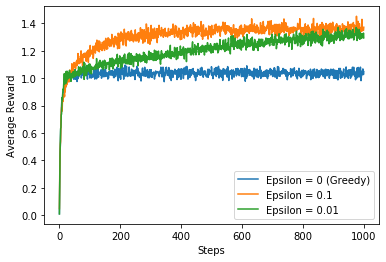

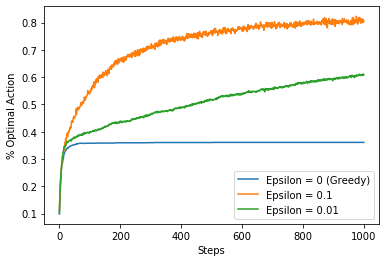

In [21]:
#a = Agent(0, None)
#b = Agent(0.1, None)
#c = Agent(0.01, None)

#Agent.experiment([a,b,c], 2000, 1000, ["Epsilon = 0 (Greedy)", "Epsilon = 0.1", "Epsilon = 0.01"], 0, 1, 10, True)

### Figure 2.3

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:22<00:00,  9.89it/s]


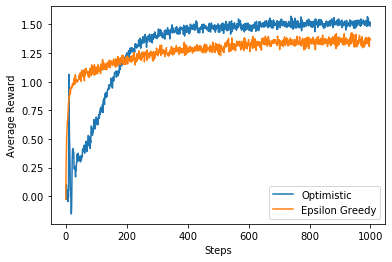

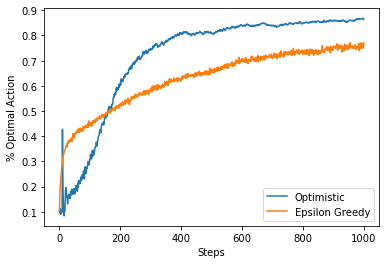

In [22]:
#a = OptimisticAgent(0, 0.1, 5)
#b = Agent(0.1, 0.1)

#Agent.experiment([a, b], 2000, 1000, ["Optimistic", "Epsilon Greedy"], 0, 1, 10, True)

### Figure 2.4

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:47<00:00,  4.90it/s]


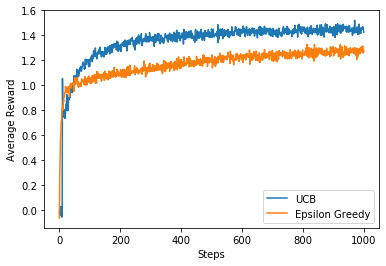

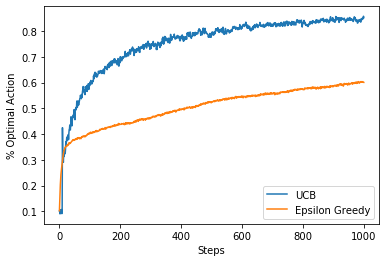

In [23]:
#a = UCB(None, 2)
#b = Agent(0.1, None)

#Agent.experiment([a, c], 2000, 1000, ["UCB", "Epsilon Greedy"], 0, 1, 10, True)

### Figure 2.6

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:12<00:00,  4.06it/s]


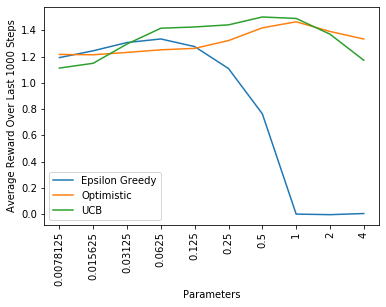

In [24]:
#Agent.parameter_study([1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4], None, .1, None, 2000, 1000, ['Epsilon Greedy', 'Optimistic', 'UCB'], 0, 1, 10, 1000, True)